In [1]:
import numpy as np 
import yt 
import aglio
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt 

build a test dataset

In [140]:
r = np.linspace(6371.-2000, 6371, 100)
lat = np.linspace(20, 25, 80)
lon = np.linspace(360-130, 360-125, 70) 

def get_test_array(r, lat, lon):
    
    r_g, lat_g, lon_g = np.meshgrid(r, lat , lon, indexing='ij')
    
    vals = np.sin((lat_g - lat.mean()) * np.pi/180. * 2 * np.pi * 50)
    vals += np.sin((lon_g - lon.mean()) * np.pi/180. * 2 * np.pi * 50)
    vals = vals * (1 - .5 * (r_g - r.min())/(r.max()-r.min()))
    return r_g, lat_g, lon_g, np.abs(vals)

In [141]:
r_g, lat_g, lon_g, field_vals = get_test_array(r, lat, lon)
r_g.shape

(100, 80, 70)

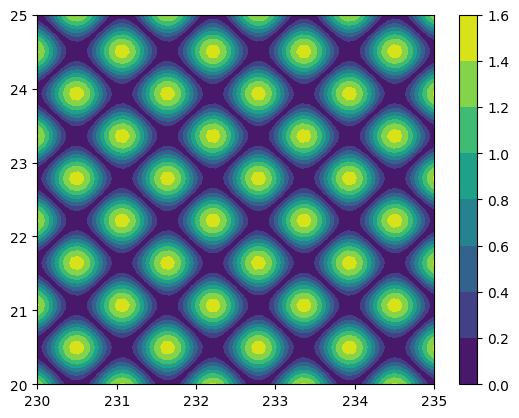

In [142]:
plt.contourf(lon, lat, field_vals[50, :, :])
plt.colorbar()

In [143]:
field_vals[:, :, 50].shape

(100, 80)

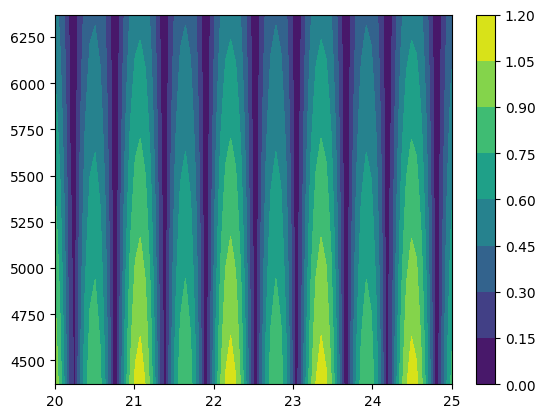

In [144]:
plt.contourf(lat, r, field_vals[:, :, 50])
plt.colorbar()

In [145]:
from typing import List 


bbox = [[r.min(), r.max()], [lat.min(), lat.max()], [lon.min(), lon.max()]]

def normalize_coord(dim_vals, dim_index):
    return (dim_vals - bbox[dim_index][0]) / (bbox[dim_index][1] -  bbox[dim_index][0])
    
                    
def get_kdtree(coord_arrays: List[np.ndarray], **kwargs):
    n_dims = len(coord_arrays)
    normalized_coords = []
    for idim in range(n_dims):
        assert coord_arrays[idim].shape == coord_arrays[0].shape

    for idim in range(n_dims):
        dim_1d = coord_arrays[idim].ravel()        
        normalized_coords.append(normalize_coord(dim_1d, idim))


    normalized_coords = np.column_stack(normalized_coords)
    return cKDTree(normalized_coords, **kwargs)        

In [146]:
bbox

[[4371.0, 6371.0], [20.0, 25.0], [230.0, 235.0]]

In [168]:
field_vals_1d = field_vals.ravel() 
the_tree = get_kdtree([r_g, lat_g, lon_g,])

def _mask_outside_bounds(r, lat, lon):
    inside = r > bbox[0][0]
    inside = (inside) & (r < bbox[0][1])
    inside = (inside) & (lat < bbox[1][1])
    inside = (inside) & (lat > bbox[1][0])
    inside = (inside) & (lon < bbox[2][1])
    inside = (inside) & (lon > bbox[2][0])
    return ~inside 
    
def sample_field(field_name, x, y, z):

    fill_val = 0.0 # np.nan 
    
    orig_shape = x.shape 
    print(orig_shape)
    
    # find native coordinate position 
    r, lat, lon = aglio.coordinate_transformations.cart2sphere(x, y, z, geo=True, deg=True)
    r = r.ravel()
    lat = lat.ravel()
    lon = lon.ravel() 

    # build bounds mask
    outside = _mask_outside_bounds(r, lat, lon)
    
    r = normalize_coord(r, 0)
    lat = normalize_coord(lat, 1)
    lon = normalize_coord(lon, 2)

    # query the tree
    dists, indexs = the_tree.query(np.column_stack([r, lat, lon]), k=1)

    # select field values     
    indexs[outside] = 0
    vals = field_vals_1d[indexs]
    vals[outside] = fill_val
    
    return vals.reshape(orig_shape)

In [169]:
xyz_g = aglio.coordinate_transformations.geosphere2cart(lat_g, lon_g, r_g)
bbox_cart = np.array([ [dim.min(), dim.max()] for dim in xyz_g])
bbox_cart

array([[-3848.22909032, -2272.20661226],
       [-4904.08445764, -3034.66310439],
       [ 1494.97004648,  2692.50094555]])

In [170]:
x_sample = np.linspace(bbox_cart[0][0], bbox_cart[0][1], 75)
y_sample = np.linspace(bbox_cart[1][0], bbox_cart[1][1], 85)
z_sample = np.linspace(bbox_cart[2][0], bbox_cart[2][1], 90)
x_sample, y_sample, z_sample = np.meshgrid(x_sample, y_sample, z_sample, indexing='ij')

sampled_vals = sample_field('foo', x_sample, y_sample, z_sample)
sampled_vals.shape

(75, 85, 90)


(75, 85, 90)

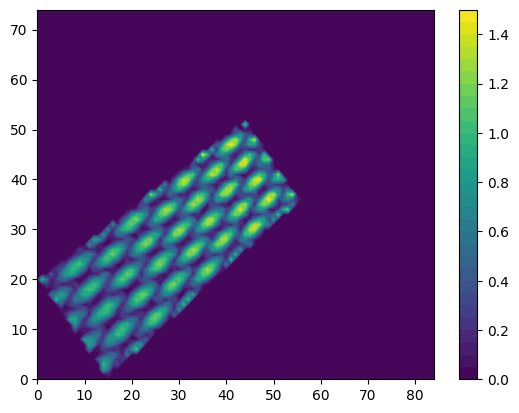

In [171]:
plt.contourf(sampled_vals[:, :, 55],levels=30)
plt.colorbar()

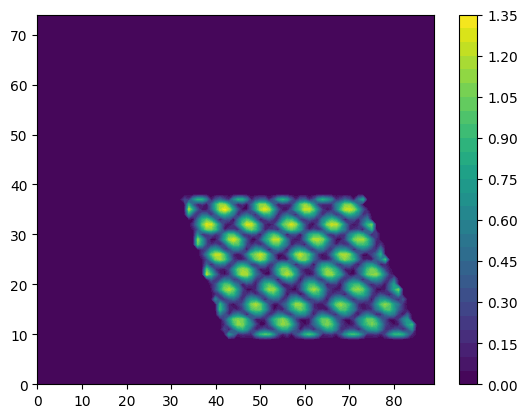

In [172]:
plt.contourf(sampled_vals[:, 25, : ],levels=30)
plt.colorbar()

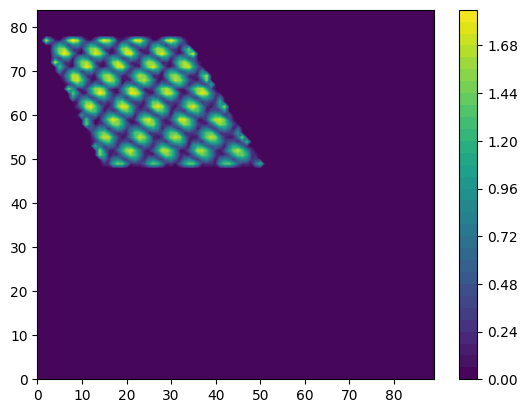

In [173]:
plt.contourf(sampled_vals[55, :, : ],levels=30)
plt.colorbar()

In [174]:
def _reader(grid, field_name):
    # grid: a yt grid object
    _, fname = field_name

    # first get the internal yt index ranges
    si = grid.get_global_startindex()
    ei = si + grid.ActiveDimensions

    # get the cartesian points for which we want to sample the field 
    x = grid[("index", "x")]
    y = grid[("index", "y")]
    z = grid[("index", "z")]
    
    vals = sample_field(field_name, x, y, z)
    
    return vals


In [175]:
data = {'density': _reader}
shp = (128, 128, 128)
ds = yt.load_uniform_grid(data, shp, bbox=bbox_cart, length_unit='km')

yt : [INFO     ] 2023-10-31 12:53:00,841 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-10-31 12:53:00,842 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-10-31 12:53:00,842 Parameters: domain_left_edge          = [-3848.22909032 -4904.08445764  1494.97004648]
yt : [INFO     ] 2023-10-31 12:53:00,843 Parameters: domain_right_edge         = [-2272.20661226 -3034.66310439  2692.50094555]
yt : [INFO     ] 2023-10-31 12:53:00,843 Parameters: cosmological_simulation   = 0


(128, 128, 128)


yt : [INFO     ] 2023-10-31 12:53:02,846 xlim = -3848.229090 -2272.206612
yt : [INFO     ] 2023-10-31 12:53:02,847 ylim = -4904.084458 -3034.663104
yt : [INFO     ] 2023-10-31 12:53:02,849 xlim = -3848.229090 -2272.206612
yt : [INFO     ] 2023-10-31 12:53:02,850 ylim = -4904.084458 -3034.663104
yt : [INFO     ] 2023-10-31 12:53:02,852 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



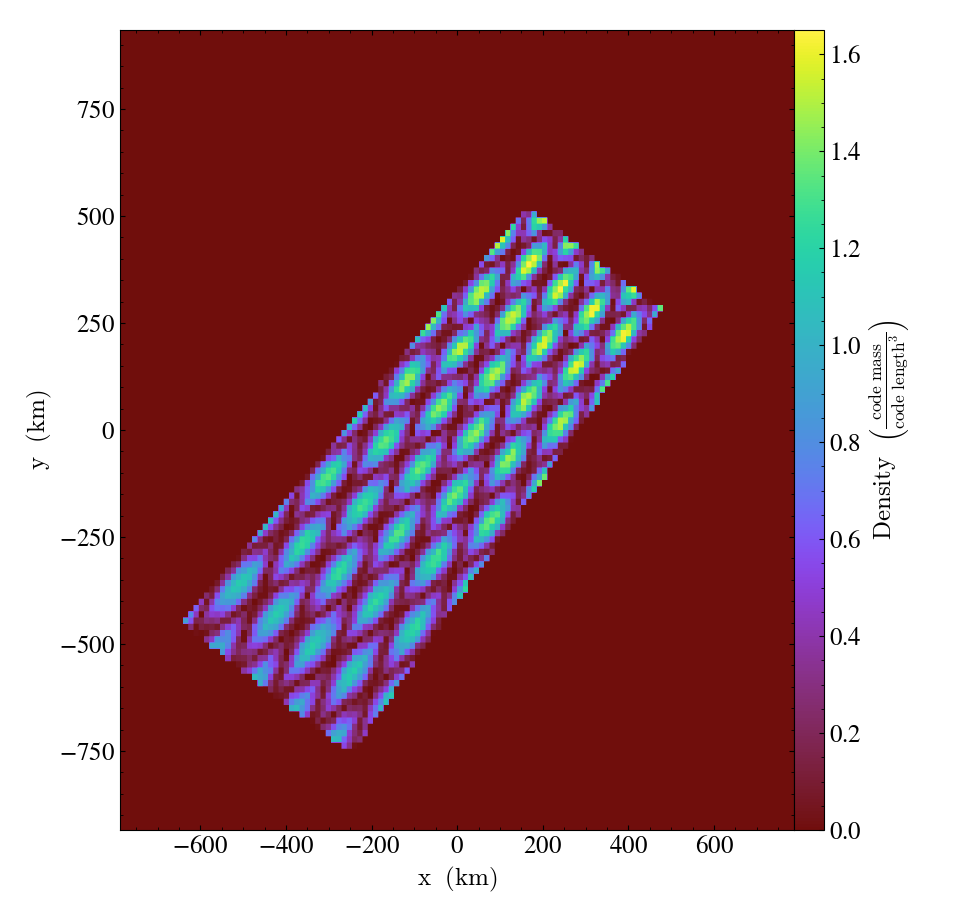

In [176]:
slc = yt.SlicePlot(ds, 'z', ('stream', 'density'))
slc.set_log(('stream', 'density'), False)

(128, 128, 128)


yt : [INFO     ] 2023-10-31 12:53:07,078 Projection completed
yt : [INFO     ] 2023-10-31 12:53:07,078 xlim = -3848.229090 -2272.206612
yt : [INFO     ] 2023-10-31 12:53:07,079 ylim = -4904.084458 -3034.663104
yt : [INFO     ] 2023-10-31 12:53:07,081 xlim = -3848.229090 -2272.206612
yt : [INFO     ] 2023-10-31 12:53:07,081 ylim = -4904.084458 -3034.663104
yt : [INFO     ] 2023-10-31 12:53:07,082 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



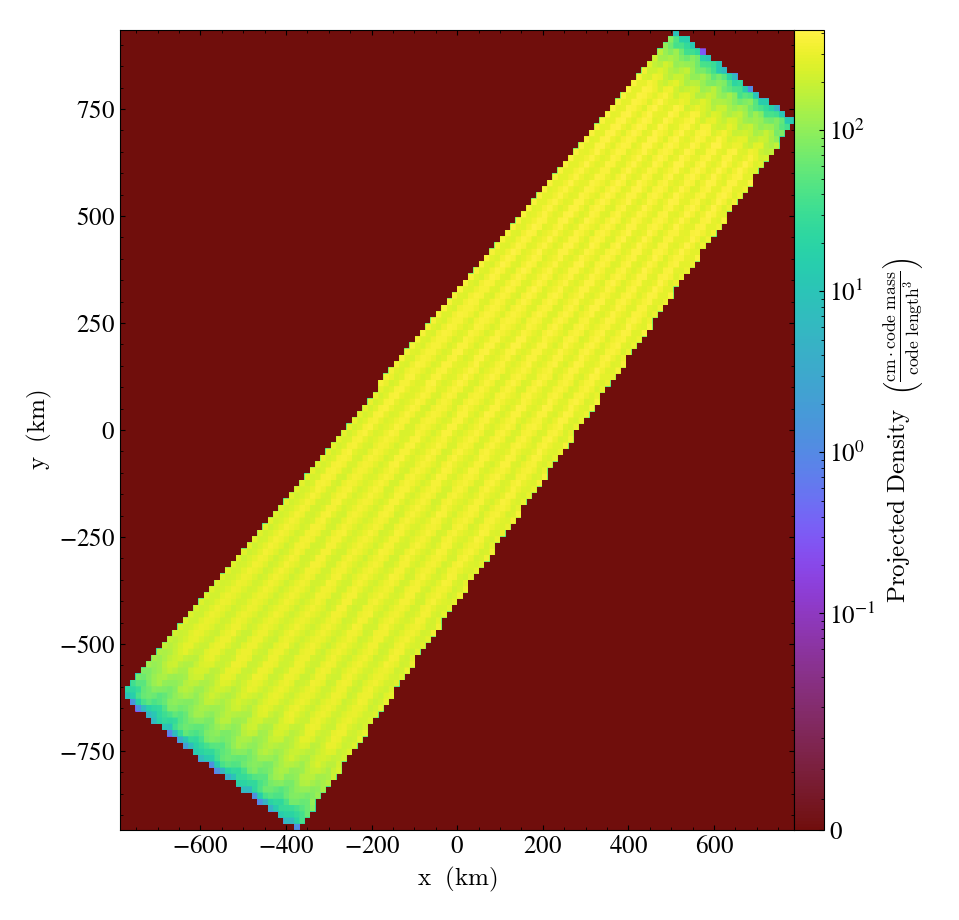

In [177]:
yt.ProjectionPlot(ds, 'z', ('stream', 'density'))